In [1]:
import sumie
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import skimage

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
model = torchvision.models.densenet121(pretrained=True).eval()
sumie.utils.remove_inplace(model)
#model.features[30] = torch.nn.AdaptiveMaxPool2d((7,7))
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU()
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU()
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU()
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU()
        (conv1): Conv2d(9

100%|██████████| 1000/1000 [01:59<00:00,  5.68it/s]


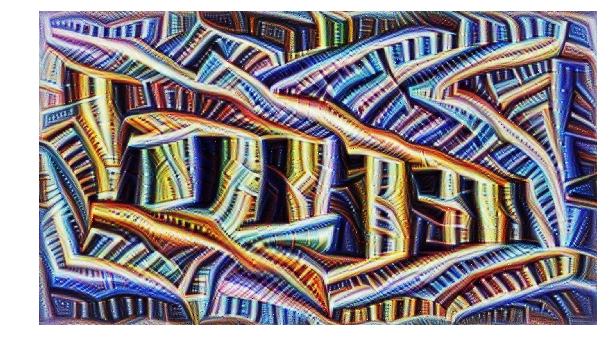

In [6]:
import math

def change_scale(opt, i):
    if i % 15 == 0:
        opt.image.transforms[1].factor *= 1.06
        
class Downsample(torch.nn.Module):
    
    def __init__(self, factor):
        super(Downsample, self).__init__()
        self.factor = factor
        

    def forward(self, x):
        _, _, h, w = x.shape
        pool_size = tuple(math.ceil(el*self.factor) for el in (h, w))
        m = torch.nn.AdaptiveAvgPool2d(pool_size)
        
        return m(x)

        
im = sumie.Image((1920, 1080), param='fft', transforms=[
                    sumie.transforms.PositionJitter(32),
                    #Downsample(0.125/16),
                    sumie.transforms.Interpolate(0.125/16),
                    sumie.transforms.RotationJitter(0.1),
                    sumie.transforms.PositionJitter(8),
                    sumie.transforms.ScaleJitter(1.01),
                    sumie.transforms.Normalise(),
              ]
            )

device = 'cuda'
im.to(device)
model.to(device)
#channel = sumie.objectives.ConvChannel(model.features[22], 15, func=torch.std)
#obj2 = sumie.objectives.ConvChannel(model.features[10], 43, func=torch.std)
#combined = sumie.objectives.Composite([channel, obj2], [1, 10])
selected_module = list(model.modules())[87]
dream = sumie.objectives.DeepDream(selected_module)
opt = sumie.Optimiser(im, model, dream)
opt.add_callback(change_scale)
#opt.add_callback(change_combined)

opt.run(iterations=1000, progress=True, lr=0.02, output='tmp', output_skip=5)
sumie.vis.show(im.get_image(), figsize=(10,10))

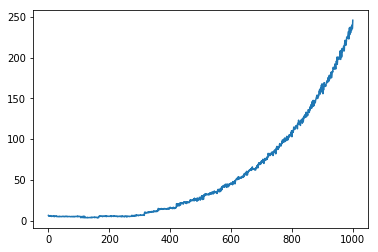

In [4]:
plt.plot([x.item() for x in opt.history])

In [5]:
im.transforms[0].factor


AttributeError: 'PositionJitter' object has no attribute 'factor'

In [ ]:
 opt.image.transforms[1].factor

In [ ]:
HTML(anim.to_html5_video())